This code is an implementation of a **time series forecasting model using XGBoost**, a popular gradient boosting algorithm. The model is trained on a dataset of unit sales data for a number of unique items and stores, and the goal is to predict future unit sales for each unique item-store combination.

The code begins by reading in the dataset and performing some preprocessing steps, including adding a unique ID column, dropping irrelevant columns, and one-hot encoding the category column. It then splits the data into training and test sets for each unique item-store combination and performs cross-validation on the training data using a TimeSeriesSplit.

The XGBoost model is then trained on the training data for each unique item-store combination, and the model is used to make predictions for the next day's unit sales using a sliding window approach. The predictions are stored in a dataframe along with the actual values, and the results are plotted for each unique item-store combination.

Overall, the code implements a robust and flexible time series forecasting model that can be easily adapted to other datasets and forecasting problems.

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import xgboost as xgb

# Define the path to 'total.csv'
#total_csv_path = '/kaggle/input/total-final/total.csv'
total_csv_path = '/kaggle/input/total-with-category/total_with_category.csv'

# Load 'total.csv' and set index to 'date'
#data = pd.read_csv(total_csv_path, parse_dates=['date'], index_col='date')
data = pd.read_csv(total_csv_path)
data = data[data['store'] == 548]

# Add 'unique_id' column
#data['unique_id'] = data['item_nbr'].astype(str) + '_' + data['store'].astype(str)
data['unique_id'] = data['item_nbr'].astype(int) 

# Drop 'item_nbr' and 'store' columns
data.drop(['item_nbr', 'store'], axis=1, inplace=True)

# Select 1 random unique_ids and filter the data
#random_unique_ids = random.sample(list(data['unique_id'].unique()), 5)
random_unique_ids = data['unique_id'].unique()
data = data[data['unique_id'].isin(random_unique_ids)]

#data = data.drop('index', axis=1)
# Sort the data by 'unique_id' and 'date'
data.sort_values(by=['unique_id', 'date'], inplace=True)

# Convert the date column to a datetime object and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
                        
# Assuming the data is already loaded into the DataFrame 'data'
data['category'] = data['category'].fillna('undefined')

# One-hot encoding for the 'category' column if there are more categories
data = pd.get_dummies(data, columns=['category'])

data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,unit_sales,bogo,circular_discount,circular,circedlp,coupon,discount_value,discount,fp_discount,front_page,fpedlp,gas,nopromo,unique_id,category_GROCERY,category_MEAT,category_PRODUCE
date,,,,,,,,,,,,,,,,,
2021-01-23,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12806,1,0,0
2021-01-24,4.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12806,1,0,0
2021-01-25,2.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12806,1,0,0
2021-01-26,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12806,1,0,0
2021-01-27,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12806,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-18,1.495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,200047863,0,0,1
2023-02-19,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,200047863,0,0,1
2023-02-20,3.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,200047863,0,0,1


**Cross-validation** is a technique used to evaluate the performance of a machine learning model by training and testing it on different subsets of the data. In this case, the TimeSeriesSplit class is used to split the time series data into multiple folds to evaluate the model's performance over time.

In [3]:
train_ratio = 0.8

# Create a dictionary to store train and test data for each unique_id
train_test_data = {}

for i, unique_id in enumerate(random_unique_ids):
    unique_id_data = data[data['unique_id'] == unique_id]
    train_size = int(len(unique_id_data) * train_ratio)
    train = unique_id_data.iloc[:train_size]
    test = unique_id_data.iloc[train_size:]

    # Perform cross-validation on the train set
    train = train.sort_index()

    tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)

    # Create a list to store train and test folds for each unique_id
    train_test_folds = []
    for train_idx, val_idx in tss.split(train):
        train_fold = train.iloc[train_idx]
        test_fold = train.iloc[val_idx]
        train_test_folds.append((train_fold, test_fold))

    # Store train and test data in the dictionary
    train_test_data[unique_id] = {'train': train, 'test': test, 'folds': train_test_folds}


# Train

In [4]:
# Concatenate train sets from all unique_ids
all_train_data = pd.concat([train_test_data[unique_id]['train'] for unique_id in random_unique_ids])

all_train_data = all_train_data.sort_index()

# Create a TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(all_train_data):
    train_fold = all_train_data.iloc[train_idx]
    val_fold = all_train_data.iloc[val_idx]

    FEATURES = ['unique_id','bogo', 'circular_discount', 'circular', 'circedlp', 'coupon', 'discount_value', 'discount', 'fp_discount', 'front_page', 'fpedlp', 'gas', 'nopromo']
    TARGET = 'unit_sales'

    X_train = train_fold[FEATURES]
    y_train = train_fold[TARGET]

    X_val = val_fold[FEATURES]
    y_val = val_fold[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:2.70308	validation_1-rmse:2.31404
[100]	validation_0-rmse:2.02658	validation_1-rmse:1.72628
[200]	validation_0-rmse:1.91246	validation_1-rmse:1.64262
[300]	validation_0-rmse:1.89262	validation_1-rmse:1.63404
[400]	validation_0-rmse:1.88680	validation_1-rmse:1.63306
[417]	validation_0-rmse:1.88614	validation_1-rmse:1.63319
[0]	validation_0-rmse:2.69146	validation_1-rmse:2.52884
[100]	validation_0-rmse:2.01632	validation_1-rmse:1.97456
[200]	validation_0-rmse:1.90242	validation_1-rmse:1.92935
[251]	validation_0-rmse:1.88867	validation_1-rmse:1.93044
[0]	validation_0-rmse:2.68330	validation_1-rmse:2.54023
[100]	validation_0-rmse:2.01536	validation_1-rmse:1.91633
[200]	validation_0-rmse:1.90330	validation_1-rmse:1.79171
[300]	validation_0-rmse:1.88472	validation_1-rmse:1.76227
[400]	validation_0-rmse:1.87946	validation_1-rmse:1.75447
[500]	validation_0-rmse:1.87558	validation_1-rmse:1.75237
[576]	validation_0-rmse:1.87329	validation_1-rmse:1.75249
[0]	validation_0-rms

In [5]:
print(f'Mean score across folds: {np.mean(scores):.4f}')
print(f'Fold scores: {scores}')

Mean score across folds: 1.6359
Fold scores: [1.6326657162147642, 1.9291557723207962, 1.7520323950397847, 1.634381981175786, 1.2314987276672507]


In [6]:
FEATURES = ['unique_id','bogo', 'circular_discount', 'circular', 'circedlp', 'coupon', 'discount_value', 'discount', 'fp_discount', 'front_page', 'fpedlp', 'gas', 'nopromo']
TARGET = 'unit_sales'

X_all = all_train_data[FEATURES]
y_all = all_train_data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=20,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-rmse:2.63031
[100]	validation_0-rmse:1.98891
[200]	validation_0-rmse:1.87995
[300]	validation_0-rmse:1.86334
[400]	validation_0-rmse:1.86069
[499]	validation_0-rmse:1.86021


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Test

In [7]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Set the window size and horizon
window_size = 14
horizon = 1

# Define a function for each iteration
def make_prediction(unique_id, train_test_data, reg, FEATURES, TARGET, window_size):
    test_unique_id = train_test_data[unique_id]['test']
    preds = []

    # Iterate through the test set using the sliding window method
    for i in range(0, len(test_unique_id) - window_size - horizon + 1):
        # Select the window from the test set
        window = test_unique_id.iloc[i:i+window_size]

        # Prepare the features and target for the window
        X_window = window[FEATURES]
        y_window = window[TARGET]

        # Fit the model on the window
        reg.fit(X_window, y_window,
                eval_set=[(X_window, y_window)],
                verbose=100)

        # Make a prediction for the next day
        X_next_day = test_unique_id[FEATURES].iloc[i+window_size]
        y_next_day = test_unique_id[TARGET].iloc[i+window_size]
        y_pred = reg.predict(np.array(X_next_day).reshape(1, -1))

        preds.append({
            'unique_id': test_unique_id['unique_id'].iloc[i+window_size],
            'date': test_unique_id.index[i+window_size],
            'actuals': y_next_day,
            'predicted': y_pred[0]
        })

    return preds

# Use joblib and tqdm to parallelize and show the progress bar
predictions = Parallel(n_jobs=-1)(
    delayed(make_prediction)(unique_id, train_test_data, reg, FEATURES, TARGET, window_size)
    for unique_id in tqdm(random_unique_ids)
)

# Prepare an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['unique_id', 'date', 'actuals', 'predicted'])

# Concatenate the results
for preds in predictions:
    predictions_df = pd.concat([predictions_df, pd.DataFrame(preds, columns=predictions_df.columns)], ignore_index=True)


100%|██████████| 5/5 [00:00<00:00, 26.22it/s]
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy ve

[0]	validation_0-rmse:1.83762
[100]	validation_0-rmse:1.63105
[200]	validation_0-rmse:1.59703
[0]	validation_0-rmse:1.91081
[300]	validation_0-rmse:1.59175
[100]	validation_0-rmse:1.55753
[0]	validation_0-rmse:2.17941
[400]	validation_0-rmse:1.59094
[200]	validation_0-rmse:1.49602
[100]	validation_0-rmse:1.54664
[0]	validation_0-rmse:0.82168
[499]	validation_0-rmse:1.59081
[300]	validation_0-rmse:1.48637
[200]	validation_0-rmse:1.42502
[100]	validation_0-rmse:0.72286
[0]	validation_0-rmse:1.58941
[400]	validation_0-rmse:1.48488
[300]	validation_0-rmse:1.40545
[200]	validation_0-rmse:0.70649
[100]	validation_0-rmse:1.44992
[499]	validation_0-rmse:1.48466
[400]	validation_0-rmse:1.40242
[200]	validation_0-rmse:1.42733
[300]	validation_0-rmse:0.70395
[0]	validation_0-rmse:1.87389
[499]	validation_0-rmse:1.40196
[300]	validation_0-rmse:1.42384
[400]	validation_0-rmse:0.70356
[100]	validation_0-rmse:1.55759
[0]	validation_0-rmse:2.23949
[400]	validation_0-rmse:1.42330[499]	validation_0-rmse

In [8]:
# Display the predictions DataFrame
predictions_df['predicted'] = np.round(predictions_df['predicted'])
predictions_df

,unique_id,date,actuals,predicted
0,200029,2022-10-07,1.0,1.0
1,200029,2022-10-08,0.0,1.0
2,200029,2022-10-09,1.0,1.0
3,200029,2022-10-10,0.0,1.0
4,200029,2022-10-11,0.0,1.0
...,...,...,...,...
690,600251,2023-02-18,0.0,0.0
691,600251,2023-02-19,0.0,0.0
692,600251,2023-02-20,0.0,0.0
693,600251,2023-02-21,0.0,0.0


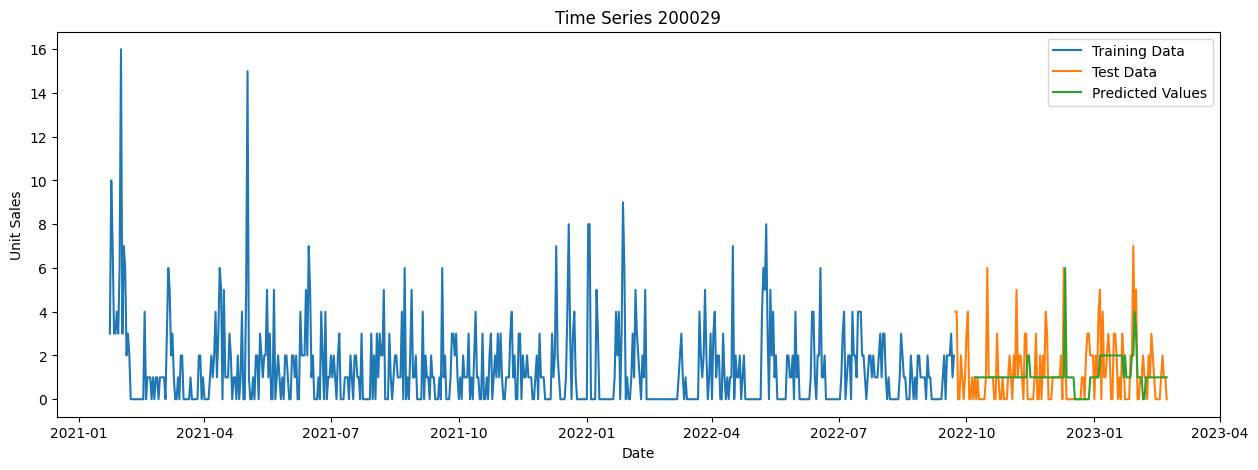

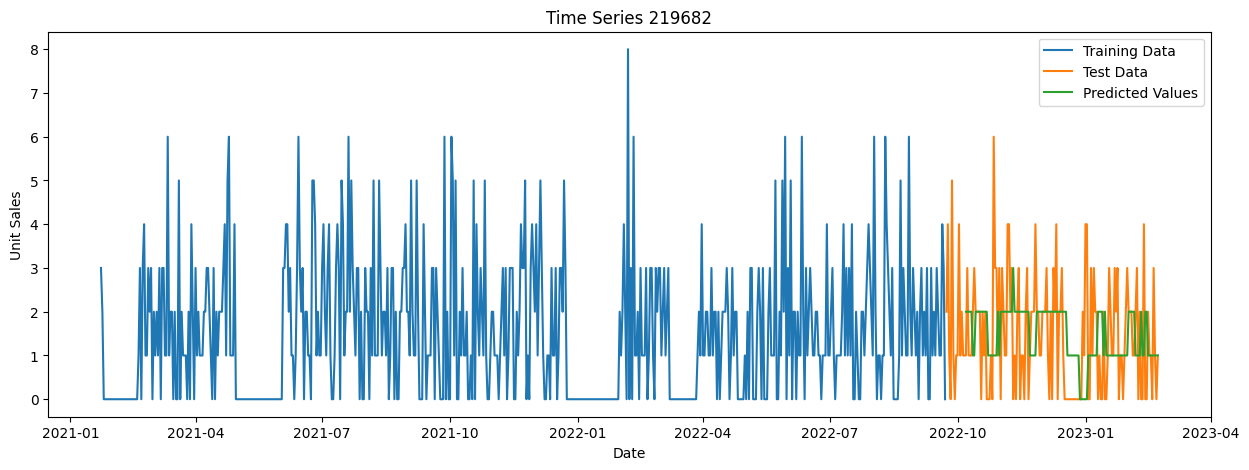

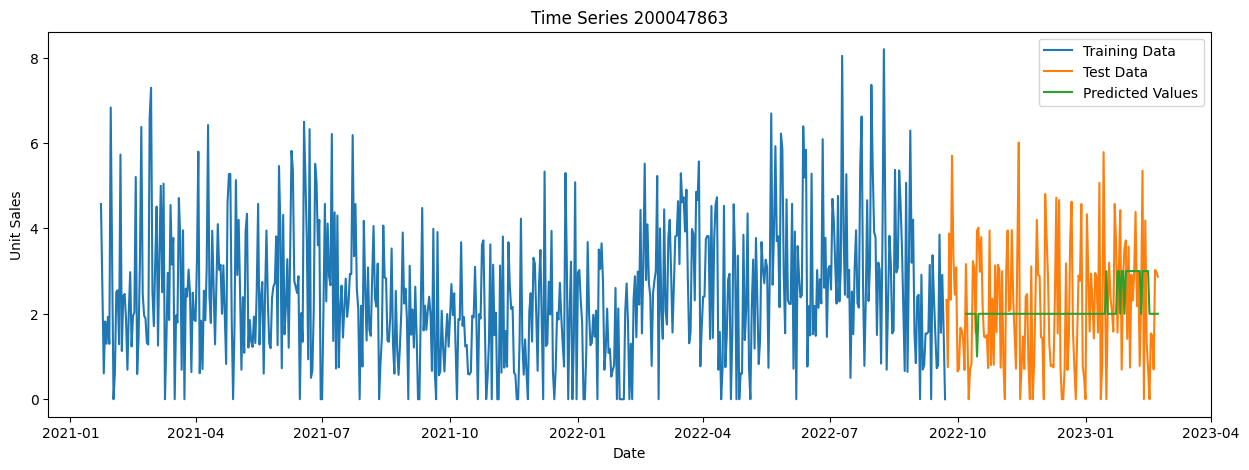

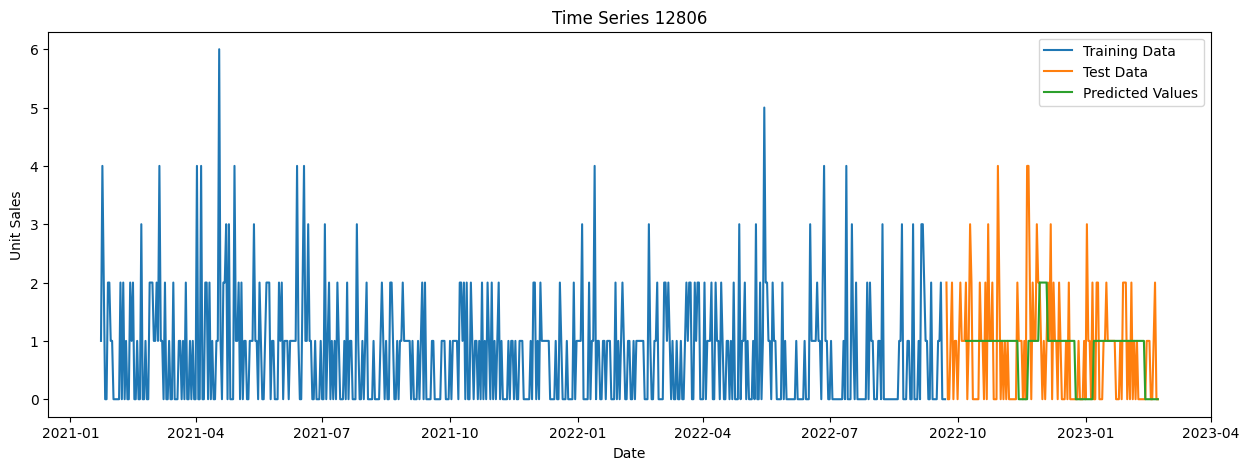

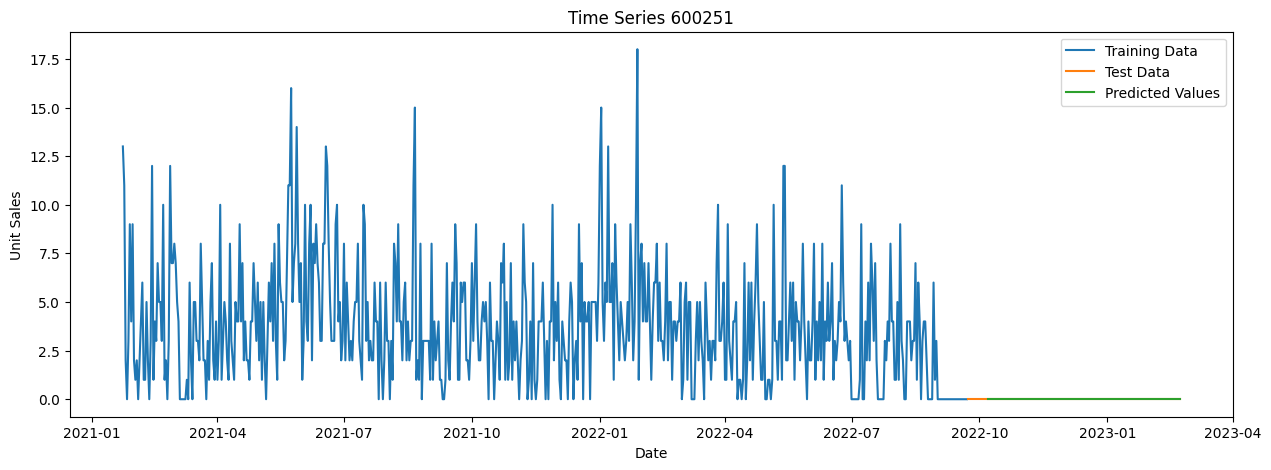

In [9]:
import matplotlib.pyplot as plt

# Loop through each unique_id in the test set
for unique_id in random_unique_ids:
    # Filter the data for the current unique_id
    train_filtered = train_test_data[unique_id]['train']
    test_filtered = train_test_data[unique_id]['test']
    results_filtered = predictions_df[predictions_df['unique_id'] == unique_id]

    # Extract the unit sales values for the current unique_id
    Y_train_filtered = train_filtered[TARGET].values
    Y_test_filtered = test_filtered[TARGET].values

    # Get the predicted values directly from the 'results_filtered' DataFrame
    Y_pred_filtered = results_filtered['predicted'].values

    # Plot the training data, test data, and predicted values for the current unique_id
    plt.figure(figsize=(15, 5))
    plt.plot(train_filtered.index[-len(Y_train_filtered):], Y_train_filtered, label='Training Data')
    plt.plot(test_filtered.index[:len(Y_test_filtered)], Y_test_filtered, label='Test Data')
    plt.plot(results_filtered['date'][:len(Y_pred_filtered)], Y_pred_filtered, label='Predicted Values')
    plt.title(f"Time Series {unique_id}")
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()

# Evaluation Metrics

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_scaled_error(actuals, predicted, seasonality=1):
    mae = np.mean(np.abs(actuals - predicted))
    naive_mae = np.mean(np.abs(actuals[seasonality:] - actuals[:-seasonality]))
    return mae / naive_mae

results = []

# Loop through each unique_id in the predictions_df
for unique_id in random_unique_ids:
    unique_id_predictions = predictions_df[predictions_df['unique_id'] == unique_id]
    actuals = unique_id_predictions['actuals'].values
    predicted = unique_id_predictions['predicted'].values

    # Calculate the error metrics
    mae = mean_absolute_error(actuals, predicted)
    rmse = np.sqrt(mean_squared_error(actuals, predicted))
    mase = mean_absolute_scaled_error(actuals, predicted)

    results.append({'unique_id': unique_id,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MASE': mase})

# Save the results in a new DataFrame
results_df = pd.DataFrame(results)

results_df.to_csv('metrics_xgboost.csv', index=False)

results_df

/tmp/ipykernel_227/1481390038.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return mae / naive_mae


,unique_id,MAE,RMSE,MASE
0,200029,1.035971,1.454341,0.877080
1,219682,1.100719,1.431908,0.904162
2,200047863,1.257043,1.499649,0.778250
3,12806,0.820144,1.072884,0.884218
4,600251,0.000000,0.000000,NaN


In [11]:
import plotly.graph_objs as go

# Create a box plot for MAE
trace1 = go.Box(
    y=results_df['MAE'],
    name="MAE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for RMSE
trace2 = go.Box(
    y=results_df['RMSE'],
    name="RMSE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for MASE
trace3 = go.Box(
    y=results_df['MASE'],
    name="MASE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a layout for the box plots
layout = go.Layout(
    title="Evaluation Metrics Box Plots",
    yaxis=dict(title="Value"),
    boxmode='group'
)

# Combine the traces and layout into a single figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Plot the figure
fig.show()

# Interpretability

# Built-in Interpretability


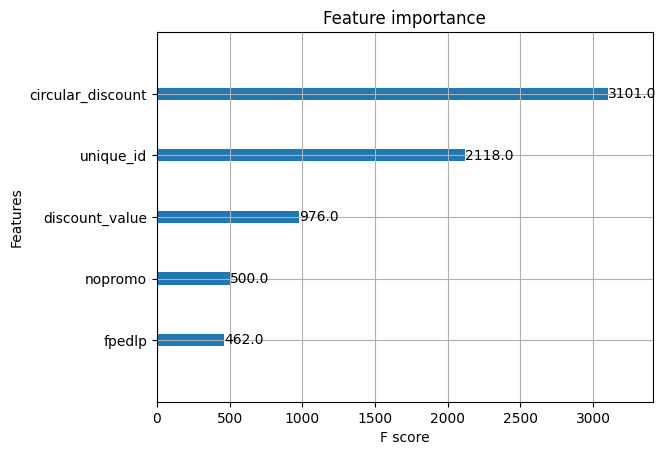

In [12]:
xgb.plot_importance(reg)
plt.show()

# SHAP


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


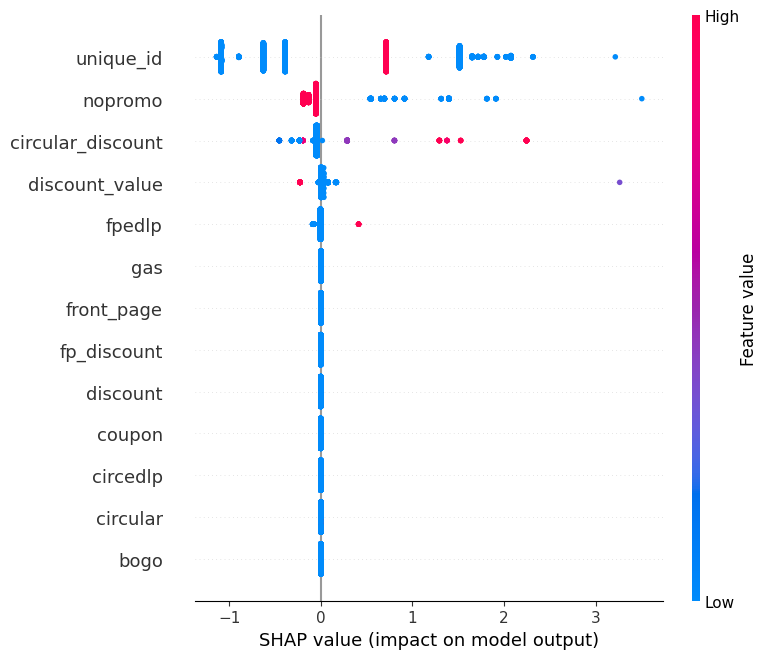

In [13]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Create a TreeExplainer object
explainer = shap.TreeExplainer(reg)

# Calculate SHAP values
shap_values = explainer.shap_values(X_all)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_all)

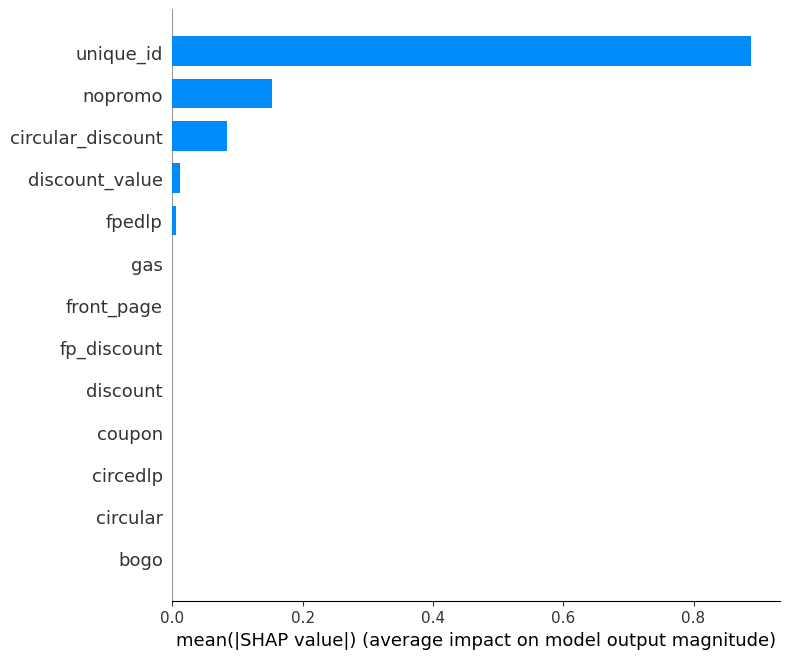

In [14]:
# Calculate SHAP values for the validation data
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_all)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_all, plot_type="bar")

In [18]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_all)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_all.iloc[0,:])

In [17]:
# Set the number of samples to be visualized
sample_size = 200

# Randomly sample a subset of the dataset
random_indices = np.random.choice(X_all.shape[0], size=sample_size, replace=False)
X_sample = X_all.iloc[random_indices]

# Compute the SHAP values for the sample
shap_values_sample = explainer.shap_values(X_sample)

# Create the force plot for the sampled dataset
shap.force_plot(explainer.expected_value, shap_values_sample, X_sample)